# Web search personalisation Based on Ant Colony 

## This Python script is designed to scrape text content from specified URLs and store the data in a Pandas DataFrame, which is then saved to a CSV file.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Function to scrape text content from a URL
def scrape_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check for successful response

        soup = BeautifulSoup(response.text, 'html.parser')
        text_content = soup.get_text(separator=' ', strip=True)
        
        return text_content
    except requests.exceptions.RequestException as e:
        print(f"Error accessing {url}: {e}")
        return None

# Example URLs to scrape (replace with your own URLs)
urls_to_scrape = [
    "https://www.who.int/india/health-topics/diabetes",
    "https://www.niddk.nih.gov/health-information/diabetes/overview/what-is-diabetes"
]

# Scraping text content from each URL
data = {'url': [], 'text_content': []}
for url in urls_to_scrape:
    text_content = scrape_url(url)
    if text_content:
        data['url'].append(url)
        data['text_content'].append(text_content)

# Creating a DataFrame from the scraped data
df = pd.DataFrame(data)

# Saving the DataFrame to a CSV file
df.to_csv('web_scraped_data.csv', index=False)

In [2]:
df['text_content']

0    Diabetes - India Global Regions WHO Regional w...
1    What Is Diabetes? - NIDDK Skip to main content...
Name: text_content, dtype: object

## Display the Orignal text for each row

In [3]:
for index, row in df.iterrows():
    print(f"URL: {row['url']}")
    print(f"Original Text: {row['text_content']}")

URL: https://www.who.int/india/health-topics/diabetes
Original Text: Diabetes - India Global Regions WHO Regional websites Africa Americas South-East Asia Europe Eastern Mediterranean Western Pacific Countries Countries in the WHO South-East Asia Region: Bangladesh Bhutan Democratic People’s Republic of Korea India Indonesia Maldives Myanmar Nepal Sri Lanka Thailand Timor-Leste When autocomplete results are available use up and down arrows to review and enter to select. Select language Select language English South-East Asia India Home Health topics Our work News Emergencies About us Home / Health topics / Diabetes Health topics Diabetes Diabetes in India Diabetes is a chronic disease that occurs either when the pancreas does not produce enough insulin or when the body cannot effectively use the insulin it produces. Insulin is a hormone that regulates blood sugar. Hyperglycaemia, or raised blood sugar, is a common effect of uncontrolled diabetes and over time leads to serious damage to

## Importing Libraries for Data Pre-Processing

In [4]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download NLTK resources (stopwords and punkt tokenizer)
import nltk

# Data Preprocessing

## 1. Remove URLs

In [5]:
df['preprocessed_text'] = df['text_content'].apply(lambda x: re.sub(r'http\S+', '', x))

## 2. Convert to lowercase

In [6]:
df['preprocessed_text'] = df['preprocessed_text'].str.lower()

## 3. Remove stopwords

In [7]:
stop_words = set(stopwords.words('english'))
df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stop_words))

In [8]:
from collections import Counter
import string

## Combine preprocessed_text into a single string

In [9]:
all_text = ' '.join(df['preprocessed_text'])

## Tokenize the text

In [10]:
words = all_text.split()

## Remove punctuation marks

In [11]:
words = [''.join(c for c in word if c not in string.punctuation) for word in words]

## Filter out empty strings

In [12]:
words = list(filter(None, words))

## Join the words back into a single string

In [13]:
preprocessed_text = ' '.join(words)

## Update the 'preprocessed_text' column in your DataFrame

In [14]:
df['preprocessed_text'] = preprocessed_text

## Display the Preprocessed text for each row

In [15]:
for index, row in df.iterrows():
    print(f"Preprocessed text :  {row['preprocessed_text']}")

Preprocessed text :  diabetes india global regions regional websites africa americas southeast asia europe eastern mediterranean western pacific countries countries southeast asia region bangladesh bhutan democratic people ’ republic korea india indonesia maldives myanmar nepal sri lanka thailand timorleste autocomplete results available use arrows review enter select select language select language english southeast asia india home health topics work news emergencies us home health topics diabetes health topics diabetes diabetes india diabetes chronic disease occurs either pancreas produce enough insulin body effectively use insulin produces insulin hormone regulates blood sugar hyperglycaemia raised blood sugar common effect uncontrolled diabetes time leads serious damage many body s systems especially nerves blood vessels india estimated 77 million people age 18 years suffering diabetes type 2 nearly 25 million prediabetics higher risk developing diabetes near future 50 people unawa

In [16]:
# Let's see the Description of Our DataSet

In [17]:
df.describe()

,url,text_content,preprocessed_text
count,2,2,2
unique,2,2,1
top,https://www.who.int/india/health-topics/diabetes,Diabetes - India Global Regions WHO Regional w...,diabetes india global regions regional website...
freq,1,1,2


In [18]:
# Let's Be Specific

In [19]:
df['preprocessed_text'].describe()

count                                                     2
unique                                                    1
top       diabetes india global regions regional website...
freq                                                      2
Name: preprocessed_text, dtype: object

In [20]:
# Let's Gain information from the Dataset

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   url                2 non-null      object
 1   text_content       2 non-null      object
 2   preprocessed_text  2 non-null      object
dtypes: object(3)
memory usage: 176.0+ bytes


# Let's apply Ant Colony Search for Words in Text 

# 1. Introduction

## -This script implements an Ant Colony Search algorithm to find a specific word in a given text. 
## -The ants navigate through the words in the text, leaving pheromone trails that influence subsequent choices. 
## -The algorithm is designed to find a path of words leading to the target word.


# 2. Code Explanation

## Dependencies

In [22]:
import random
import re

In [23]:
text = ' '.join(df['preprocessed_text'])

class AntColonySearch:
    def __init__(self, text, word_to_search, num_ants=1, alpha=1.0, beta=3.0, evaporation=0.5):
        self.text = text
        self.word_to_search = word_to_search
        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.evaporation = evaporation
        self.pheromones = {word: 1.0 for word in set(re.findall(r'\b\w+\b', self.text.lower()))}

    def select_next_word(self, current_word, remaining_words):
        # Obtain pheromone levels for the remaining words
        pheromone_levels = [self.pheromones[word] for word in remaining_words]
        total_pheromone = sum(pheromone_levels)
        
        # Calculate probabilities based on pheromone levels
        probabilities = [pheromone / total_pheromone for pheromone in pheromone_levels]

        # Make a probabilistic choice for the next word using these probabilities
        next_word_index = random.choices(range(len(remaining_words)), weights=probabilities)[0]
        next_word = remaining_words[next_word_index]

        return next_word

    def update_pheromones(self, visited_word):
        # Update pheromone levels for the visited word (you can adjust the update logic)
        evaporation_rate = 0.1  # Example: adjusting the evaporation rate
        self.pheromones[visited_word] *= (1.0 - evaporation_rate)
        # Increase pheromone level for the visited word (you can adjust this logic)
        self.pheromones[visited_word] += 1.0

    def search_word(self):
        words = re.findall(r'\b\w+\b', self.text.lower())
        start_word = random.choice(words)
        visited_words = [start_word]
        visited_set = set([start_word])  # Use a set to efficiently check for visited words

        while True:
            next_word = self.select_next_word(start_word, words)

            if next_word in visited_set:
                # Exclude already visited words from the remaining choices
                remaining_words = [word for word in words if word not in visited_set]
                if not remaining_words:
                    break
                next_word = self.select_next_word(start_word, remaining_words)

            visited_words.append(next_word)
            visited_set.add(next_word)
            self.update_pheromones(next_word)
            start_word = next_word

            # Check if the target word is reached
            if self.word_to_search in visited_set:
                break

        return list(dict.fromkeys(visited_words))  # Remove duplicates from the visited words

# Initialize and run the Ant Colony Search for a word
word_to_find = input("Enter any word: ")  # Change this to the word you want to search
acs = AntColonySearch(text, word_to_find)
found_path = acs.search_word()

# Display the found path (sequence of words leading to the target word)
print("Found Path:")
print(found_path)

Enter any word: diabetes
Found Path:
['noncommunicable', 'body', 'democratic', 'diabetes']


# Visualisation Libraries

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

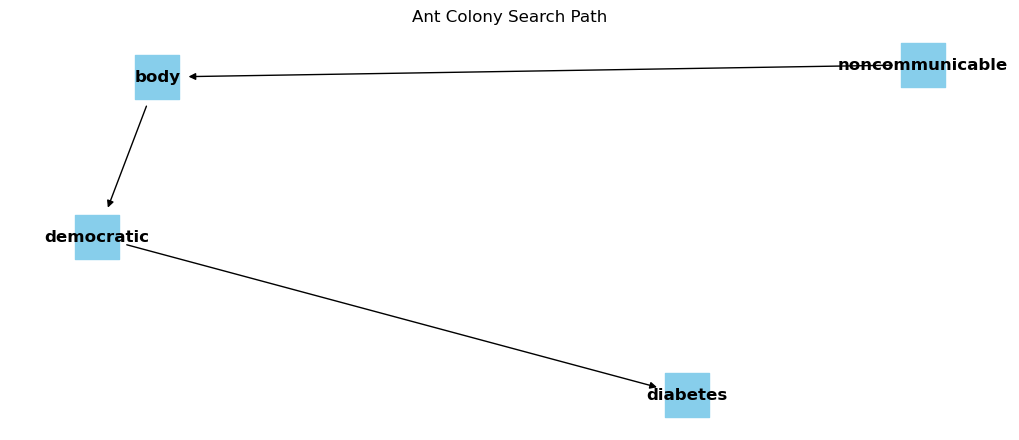

In [25]:
def visualize_search_path(found_path):
    G = nx.DiGraph()

    # Add edges based on the found path
    for i in range(len(found_path)-1):
        G.add_edge(found_path[i], found_path[i+1])

    # Set positions for the nodes (optional)
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(10, 4))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', node_shape='s', font_weight='bold', arrows=True)
    plt.title("Ant Colony Search Path")
    plt.show()
visualize_search_path(found_path)

In [26]:
#pip install wordcloud

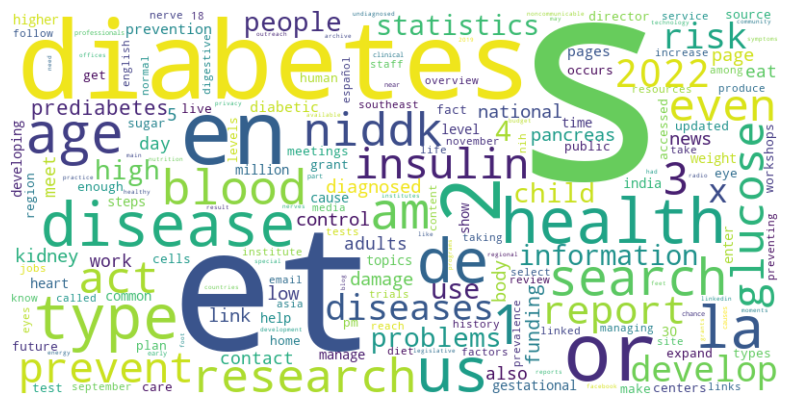

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df['preprocessed_text'] contains the preprocessed text
text = ' '.join(df['preprocessed_text'])

# Combine the words into a single string for word cloud generation
text_for_wordcloud = ' '.join(found_path)

# Generate a dictionary of word frequencies in the entire preprocessed text
word_frequencies = {word: text.lower().count(word) for word in set(re.findall(r'\b\w+\b', text.lower()))}

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


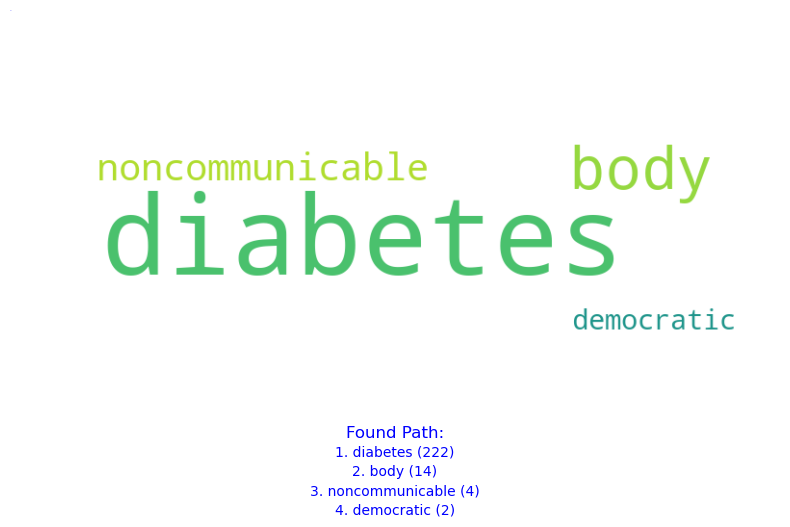

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow

# Combine the words into a single string for word cloud generation
text_for_wordcloud = ' '.join(found_path)

# Generate a dictionary of word frequencies in the entire preprocessed text
word_frequencies = {word: text.lower().count(word) for word in set(re.findall(r'\b\w+\b', text.lower()))}

# Filter frequencies based on the words in the found path
found_path_frequencies = {word: word_frequencies.get(word, 0) for word in found_path}

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(found_path_frequencies)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Sort the words in the found path by frequency (highest to lowest)
sorted_path = sorted(found_path_frequencies.items(), key=lambda x: x[1], reverse=True)

# Add systematic annotations below the word cloud
plt.annotate("Found Path:", (0.5, -0.1), xycoords="axes fraction", ha="center", va="center", fontsize=12, color='blue')

for idx, (word, freq) in enumerate(sorted_path):
    plt.annotate(f"{idx + 1}. {word} ({freq})", (0.5, -0.15 - idx * 0.05),
                 xycoords="axes fraction", ha="center", va="center", color='blue', fontsize=10)

# Add arrows indicating the direction of the path
for i in range(len(found_path) - 1):
    plt.arrow(0.5, -0.2 - (i + 1) * 0.05, 0, -0.02, head_width=0.02, head_length=0.02, fc='blue', ec='blue')

plt.show()


In [29]:
def build_kmp_table(pattern):
    table = [0] * len(pattern)
    j = 0

    for i in range(1, len(pattern)):
        if pattern[i] == pattern[j]:
            j += 1
            table[i] = j
        else:
            if j > 0:
                j = table[j - 1]
                i -= 1

    return table

def kmp_search(text, pattern):
    m, n = len(pattern), len(text)
    if m == 0 or n == 0 or m > n:
        return []

    table = build_kmp_table(pattern)
    matches = []

    i = j = 0
    while i < n:
        if pattern[j] == text[i]:
            i += 1
            j += 1

            if j == m:
                matches.append(i - j)
                j = table[j - 1]
        else:
            if j > 0:
                j = table[j - 1]
            else:
                i += 1

    return matches

# Example usage:
preprocessed_text = ' '.join(df['preprocessed_text'])
word_to_find = input("Enter any word to search: ")
matches = kmp_search(preprocessed_text, word_to_find)

if matches:
    print(f"Word '{word_to_find}' found at positions: {matches}")
else:
    print(f"Word '{word_to_find}' not found in the preprocessed text.")

Enter any word to search: diabetes
Word 'diabetes' found at positions: [0, 474, 497, 506, 521, 729, 873, 943, 1055, 1357, 1430, 1457, 1507, 1620, 1655, 1925, 2449, 2733, 3107, 3116, 3134, 3182, 3200, 3233, 3249, 3280, 3301, 3320, 3365, 3391, 3428, 3479, 3488, 3522, 3613, 3637, 3688, 3758, 3808, 3843, 3948, 3992, 4029, 4078, 4087, 4300, 4400, 4454, 4516, 4551, 4576, 4659, 4681, 4716, 4732, 4748, 4849, 4932, 4987, 5003, 5141, 5162, 5193, 5272, 5326, 5445, 5466, 5480, 5518, 5569, 5610, 5640, 5676, 5688, 5707, 5780, 5792, 5831, 5913, 5939, 5965, 6000, 6110, 6122, 6153, 6165, 6225, 6254, 6281, 6313, 6335, 6389, 6423, 6495, 6540, 6810, 6933, 7006, 7024, 7151, 7199, 7231, 7358, 7414, 7445, 7572, 7615, 7749, 7832, 8730, 9014, 9581, 10055, 10078, 10087, 10102, 10310, 10454, 10524, 10636, 10938, 11011, 11038, 11088, 11201, 11236, 11506, 12030, 12314, 12688, 12697, 12715, 12763, 12781, 12814, 12830, 12861, 12882, 12901, 12946, 12972, 13009, 13060, 13069, 13103, 13194, 13218, 13269, 13339, 13389, 

In [30]:
#pip install mlxtend

In [31]:
import random
import re

class AntColonySearch:
    def __init__(self, text, word_to_search, evaporation_rate=0.1):
        self.text = text
        self.word_to_search = word_to_search
        self.evaporation_rate = evaporation_rate
        self.pheromones = {word: 1.0 for word in set(re.findall(r'\b\w+\b', text.lower()))}
        self.best_path = []

    def select_next_word(self, current_word, remaining_words):
        pheromone_levels = [self.pheromones[word] for word in remaining_words]
        total_pheromone = sum(pheromone_levels)
        probabilities = [pheromone / total_pheromone for pheromone in pheromone_levels]
        next_word_index = random.choices(range(len(remaining_words)), weights=probabilities)[0]
        return remaining_words[next_word_index]

    def update_pheromones(self, visited_word):
        self.pheromones[visited_word] *= (1.0 - self.evaporation_rate)
        self.pheromones[visited_word] += 1.0

    def search_word(self):
        words = re.findall(r'\b\w+\b', self.text.lower())

        if self.word_to_search not in words:
            print(f"The word '{self.word_to_search}' is not present in the text.")
            return []

        start_word = random.choice(words)
        visited_words = [start_word]
        visited_set = set([start_word])
        current_path = [start_word]

        while self.word_to_search not in visited_set:
            remaining_words = [word for word in words if word not in visited_set]
            next_word = self.select_next_word(start_word, remaining_words)

            visited_words.append(next_word)
            visited_set.add(next_word)
            current_path.append(next_word)
            self.update_pheromones(next_word)
            start_word = next_word

        # Check if the current path is better than the previous best path
        if len(current_path) < len(self.best_path) or not self.best_path:
            self.best_path = current_path

        return self.best_path

# Example usage:
text = ' '.join(df['preprocessed_text'])
word_to_find = input("Enter any word: ")
acs = AntColonySearch(text, word_to_find)
best_path = acs.search_word()

# Display the best path
print("Best Path:", best_path)


Enter any word: diabetes
Best Path: ['also', 'process', 'diabetes']


In [32]:
import random
import re

class AntColonySearch:
    def __init__(self, text, word_to_search, evaporation_rate=0.1, num_paths_to_keep=5):
        self.text = text
        self.word_to_search = word_to_search
        self.evaporation_rate = evaporation_rate
        self.num_paths_to_keep = num_paths_to_keep
        self.pheromones = {word: 1.0 for word in set(re.findall(r'\b\w+\b', text.lower()))}
        self.paths = [[] for _ in range(num_paths_to_keep)]

    def select_next_word(self, current_word, remaining_words):
        pheromone_levels = [self.pheromones[word] for word in remaining_words]
        total_pheromone = sum(pheromone_levels)
        probabilities = [pheromone / total_pheromone for pheromone in pheromone_levels]
        next_word_index = random.choices(range(len(remaining_words)), weights=probabilities)[0]
        return remaining_words[next_word_index]

    def update_pheromones(self, visited_word):
        self.pheromones[visited_word] *= (1.0 - self.evaporation_rate)
        self.pheromones[visited_word] += 1.0

    def search_word(self):
        words = re.findall(r'\b\w+\b', self.text.lower())

        if self.word_to_search not in words:
            print(f"The word '{self.word_to_search}' is not present in the text.")
            return []

        for i in range(self.num_paths_to_keep):
            start_word = random.choice(words)
            visited_words = [start_word]
            visited_set = set([start_word])

            while self.word_to_search not in visited_set:
                remaining_words = [word for word in words if word not in visited_set]
                next_word = self.select_next_word(start_word, remaining_words)

                visited_words.append(next_word)
                visited_set.add(next_word)
                self.update_pheromones(next_word)
                start_word = next_word

            self.paths[i] = visited_words

        # Select the best path based on the shortest length
        best_path = min(self.paths, key=len)

        return best_path, self.paths

# Example usage:
text = ' '.join(df['preprocessed_text'])
word_to_find = input("Enter any word: ")
num_paths_to_display = 4
acs = AntColonySearch(text, word_to_find, num_paths_to_keep=num_paths_to_display)
best_path, all_paths = acs.search_word()

# Display all paths and the best path
print("All Paths:")
for i, path in enumerate(all_paths, 1):
    print(f"Path {i}: {path}")

print("\nBest Path:", best_path)


Enter any word: diabetes
All Paths:
Path 1: ['system', '77', '2', 'blood', 'healthy', 'faqs', 'health', 'insulin', 'especially', 's', 'select', 'damage', 'lanka', 'control', 'problems', 'important', 'developing', 'normal', '2019', 'body', 'diseases', 'moments', 'adults', 'uncontrolled', 'accessed', 'chat', 'diabetes']
Path 2: ['problems', '830', 'single', 'especially', 'niddk', 'resistance', 'learning', '30', 'noncommunicable', 'training', 'discovery', 'use', 'nutrition', 'type', 'part', 'diabetes']
Path 3: ['health', '2', 'kidney', 'diabetes']
Path 4: ['us', 'diabetes']

Best Path: ['us', 'diabetes']


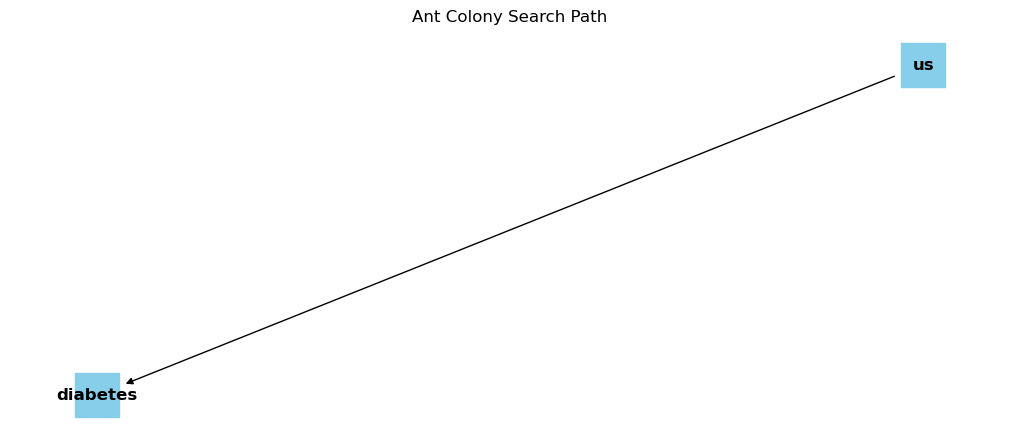

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_search_path(best_path):
    G = nx.DiGraph()

    # Add edges based on the found path
    for i in range(len(best_path) - 1):
        G.add_edge(best_path[i], best_path[i + 1])

    # Set positions for the nodes (optional)
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(10, 4))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', node_shape='s', font_weight='bold', arrows=True)
    plt.title("Ant Colony Search Path")
    plt.show()
visualize_search_path(best_path)

In [34]:
pip install --upgrade wordcloud

Note: you may need to restart the kernel to use updated packages.


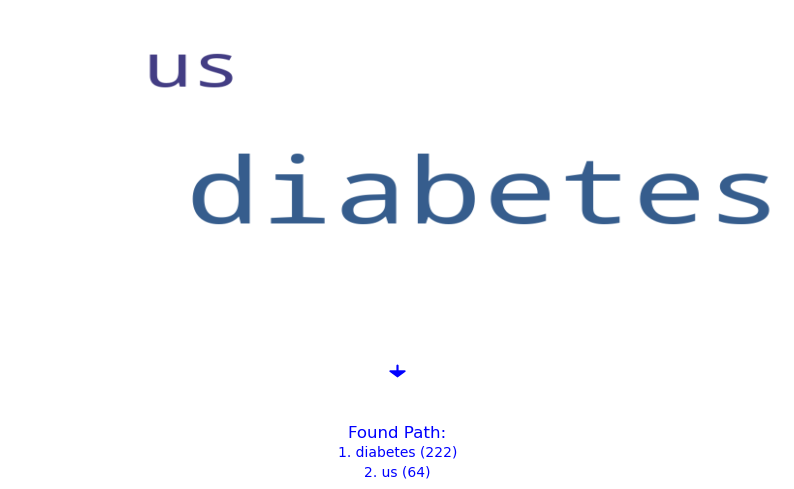

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow

# Assuming best_path is defined
text_for_wordcloud = ' '.join(best_path)

word_frequencies = {word: text.lower().count(word) for word in set(re.findall(r'\b\w+\b', text.lower()))}

found_path_frequencies = {word: word_frequencies.get(word, 0) for word in best_path}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(found_path_frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto', extent=[0, 1, 0, 1])
plt.axis('off')

sorted_path = sorted(found_path_frequencies.items(), key=lambda x: x[1], reverse=True)

plt.annotate("Found Path:", (0.5, -0.1), xycoords="axes fraction", ha="center", va="center", fontsize=12, color='blue')

for idx, (word, freq) in enumerate(sorted_path):
    plt.annotate(f"{idx + 1}. {word} ({freq})", (0.5, -0.15 - idx * 0.05),
                 xycoords="axes fraction", ha="center", va="center", color='blue', fontsize=10)

for i in range(len(best_path) - 1):
    plt.arrow(0.5, -0.2 - (i + 1) * 0.05, 0, -0.02, head_width=0.02, head_length=0.02, fc='blue', ec='blue')

plt.show()
